<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/merge_set_4class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [2]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 446, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 446 (delta 70), reused 38 (delta 14), pack-reused 307
Receiving objects: 100% (446/446), 11.08 MiB | 19.47 MiB/s, done.
Resolving deltas: 100% (247/247), done.
     | 50.0MB 210.3MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30868 sha256=3fb784f225dec668e021e4adb1acc26e99814986d39a582a0b8a175ac2ade020
  Stored in directory: /tmp/pip-ephem-wheel-cache-4hxfd59b/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


Unpack the items

In [4]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


# Load libraries
Load the necessary libraries

In [5]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns
import random


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [6]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(8, 75, 224, 224, 3) (8, 15, 224, 224, 3)
(8, 75, 224, 224, 3) (8, 15, 224, 224, 3)


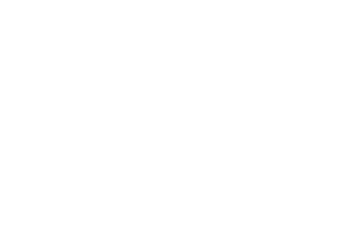

In [7]:
# Merged images load
data_train = [[]  for i in range(8)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
#data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
#data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[4] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
#data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
#data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(8)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
#data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
#data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[4] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
#data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
#data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

#plt.imshow(data_train[3,79])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(8)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
#reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
#reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[4] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
#reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
#reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(8)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
#reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
#reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[4] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
#reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
#reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



# Model
Call the base model and the top model here

### Model Architecture

In [8]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet 
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 75
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 15
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


58900480/58889256 [==============================] - 0s 0us/step
Category of interest:  Male
(150, 224, 224, 3) (30, 224, 224, 3)
Train Time: 25.26356554031372
Test Time: 2.850229501724243
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total params: 102,772,738
Trainable params: 102,772,738
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [96]:

acc = np.zeros((2,4))
for imtype in range(2):
  for cat in range(2,3):
    tf.keras.backend.clear_session()

    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 4])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
    print(train_it.shape,test_it.shape)

    
    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')
    
    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

Category of interest:  Manmade
(150, 224, 224, 3) (30, 224, 224, 3)
Train Time: 0.22277283668518066
Test Time: 0.08020186424255371
Epoch 1/30
1/1 [==============================] - 0s 18ms/step - loss: 0.7584 - accuracy: 0.6333
[0.7584006190299988, 0.6333333253860474]
Category of interest:  Manmade
(150, 224, 224, 3) (30, 224, 224, 3)
Train Time: 0.22615432739257812
Test Time: 0.07564306259155273
Epoch 1/30
1/1 [==============================] - 0s 16ms/step - loss: 0.5883 - accuracy: 0.7333
[0.5882899761199951, 0.7333333492279053]


In [99]:
acc[0,:] = [86.67,86.67,80,86.67]
acc[1,:] = [56.67,70,63,53]

### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

72.83500000000001


Text(0, 0.5, 'Δ Accuracy')

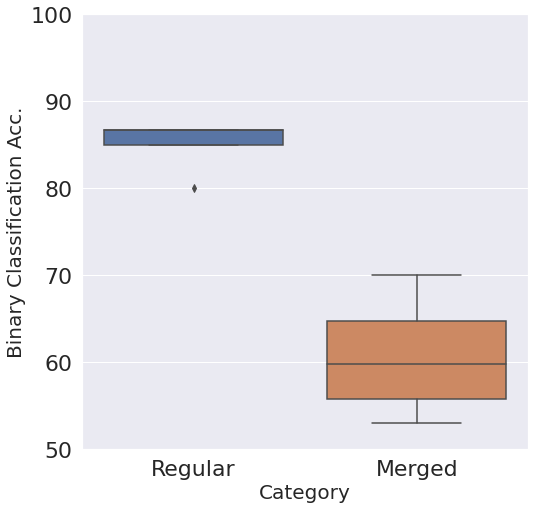

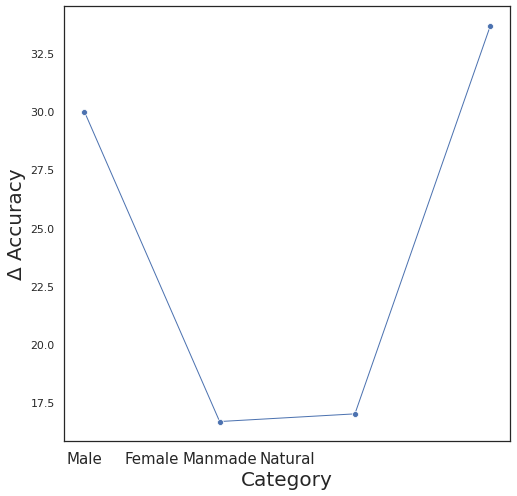

In [106]:
diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns

sns.set(style="white",rc={"lines.linewidth": 0.7})
sns.set(font_scale = 2)

plt.figure(figsize = (8,8))
ax = sns.boxplot(data = acc.T )
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'])
ax.set_ylabel('Binary Classification Acc.',size = 20)
ax.set_yticks([50,60,70,80,90,100])


# Cateogory wise performance difference
plt.figure(figsize = (8,8))
sns.set(style="white",rc={"lines.linewidth": 1})
ax = sns.lineplot(data = diff ,marker="o")
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Male','Female','Manmade','Natural'],size = 15)
ax.set_ylabel('\u0394 Accuracy',size = 20)



# Tuning Value Calculation

In [9]:
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(len(categories)): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    
    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)

Category of interest:  Male
Elapsed: 13.837868690490723s
Category of interest:  Female
Elapsed: 13.593281030654907s
Category of interest:  Manmade
Elapsed: 13.593870401382446s
Category of interest:  Natural
Elapsed: 13.706570863723755s


### Load tuning activities

In [10]:
tun_activ = []
for interest in range(len(categories)): 
  with open ('tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



300

### Calculation of tuning values for each map

In [11]:
ncats = len(categories)
# to fish out each category tun_activations
labels = np.array([0] * 75 + [1] * 75 + [2] * 75 + [3] * 75 )
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]

### Tuning quality

(0.0, 50.0)

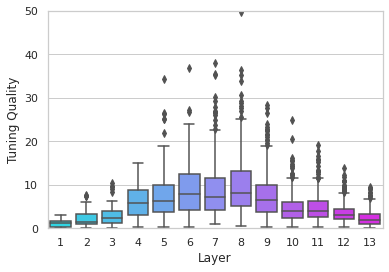

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

### Tuning quality for face images

Text(0.5, 1.0, 'Tuning quality for Face Images')

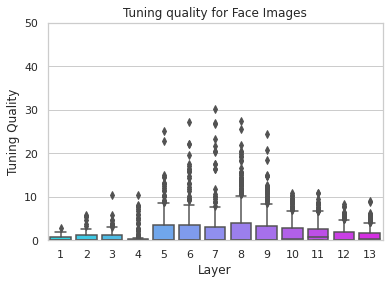

In [110]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < fc[cat][layer][map]:
        tun_q_face[layer][map] = fc[cat][layer][map]

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])
plt.title('Tuning quality for Face Images')


### Tuning quality for non face neurons

<Figure size 432x288 with 0 Axes>

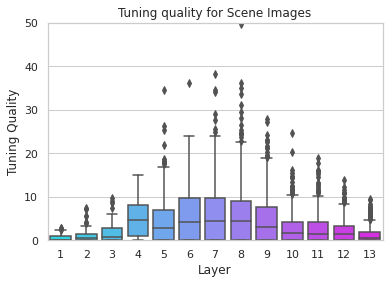

<Figure size 432x288 with 0 Axes>

In [111]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2,4):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < fc[cat][layer][map]:
        tun_q_face[layer][map] = fc[cat][layer][map]

sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_q_face,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])
plt.title('Tuning quality for Scene Images')

plt.figure()



Text(0.5, 1.0, 'Number of face selective neurons')

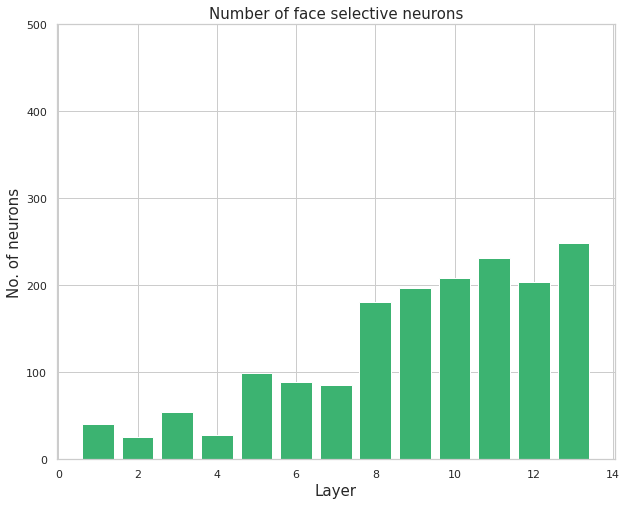

In [112]:
idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

counter = np.zeros(13)
fig = plt.figure(figsize = (10,8))
for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      counter[layer] += 1
plt.bar(x = np.arange(1,14,1),
        height = counter,
        color = 'mediumseagreen')
plt.ylim(0,500)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of neurons',size = 15)
plt.title('Number of face selective neurons',size = 15)

Text(0.5, 1.0, 'Number of selective neurons, category wise')

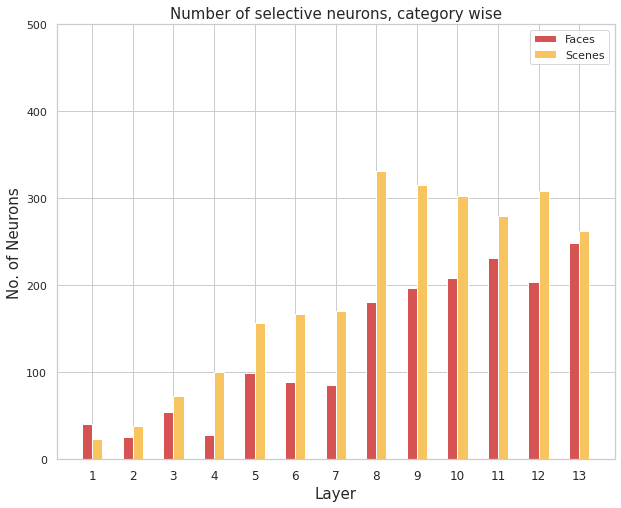

In [113]:
width = 0.25

idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1



fig, ax = plt.subplots(figsize = (10,8))
rects1 = ax.bar(np.arange(13) - width/2 , c_face, width, label='Faces',color = '#D65353')
rects2 = ax.bar(np.arange(13) + width/2, c_scene, width, label='Scenes',color = '#F7C45F')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend()

plt.ylim(0,500)
plt.xticks(np.arange(13),np.arange(1,14),size = 12)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of Neurons',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)

# Gradient Calculations

In [29]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(4, activation='softmax',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

g_labels_train = to_categorical(labels)
g_labels_test = to_categorical([0]* 15 + [1]*15 + [2]*15 + [3]*15)
g_train = np.vstack((reg_train[0],reg_train[1],reg_train[2],reg_train[3]))
g_test = np.vstack((reg_test[0],reg_test[1],reg_test[2],reg_test[3]))

G_train = model.predict(g_train)
G_test = model.predict(g_test)

history = top_model.fit(x = G_train,  y = g_labels_train,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

out = top_model.evaluate(G_test, g_labels_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
2/2 [==============================] - 0s 5ms/step - loss: 0.8094 - accuracy: 0.7333


In [35]:
calc_gradient_val = 1
if calc_gradient_val:
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(ncats):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(data_train[i],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open('gradient_values_cat', 'wb') as fp:
      pickle.dump(cat_grads, fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Elapsed: 285.843820810318s


In [ ]:
with open ('gradient_values_cat', 'rb') as fp:
    cat_grads = pickle.load(fp)

In [ ]:
corr_all = st.calc_all_corrcoeff(fc[2:4],cat_grads[2:4])

import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)
for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)

pt.plot_corr(corr_shuff,corr_all,figsize = (20,8))


In [ ]:
corr_all

# Neuron level activities

In [ ]:
calc_neuron_activ = 1

tun_activ = [[[np.empty((224,224,64)),
              np.empty((224,224,64)),
              np.empty((112,112,128)),
              np.empty((112,112,128)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512))]  for i in range(len(train_it))] for i in range(ncats)]
              
if calc_neuron_activ:
  for cat in range(len(categories)): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    for imgs,img_tensor in enumerate(train_it):
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        tun_activ[cat][imgs][l] = np.squeeze(layer_activation,0)
    

    print(f'Elapsed: {time.time() - start}s')


Category of interest:  Male
Elapsed: 6.507528066635132s
Category of interest:  Female
Elapsed: 5.899834632873535s
Category of interest:  Manmade
Elapsed: 9.026545286178589s
Category of interest:  Natural
Elapsed: 13.638540029525757s


In [ ]:
x = [[np.empty(64),
     np.empty(64),
     np.empty(128),
     np.empty(128),
     np.empty(256),
     np.empty(256),
     np.empty(256),
     np.empty(512),
     np.empty(512),
     np.empty(512),
     np.empty(512),
     np.empty(512),
     np.empty(512)] for i in range(ncats)]
     
for cat in range(ncats):
  temp = tun_activ[cat]
  for img in range(len(temp)):
    for layer in range(len(temp[img])):
      t = np.squeeze(np.array(temp[img][layer]))
      for map in range(t.shape[2]):
        x[cat][layer][map] = np.amax(t[:,:,map])

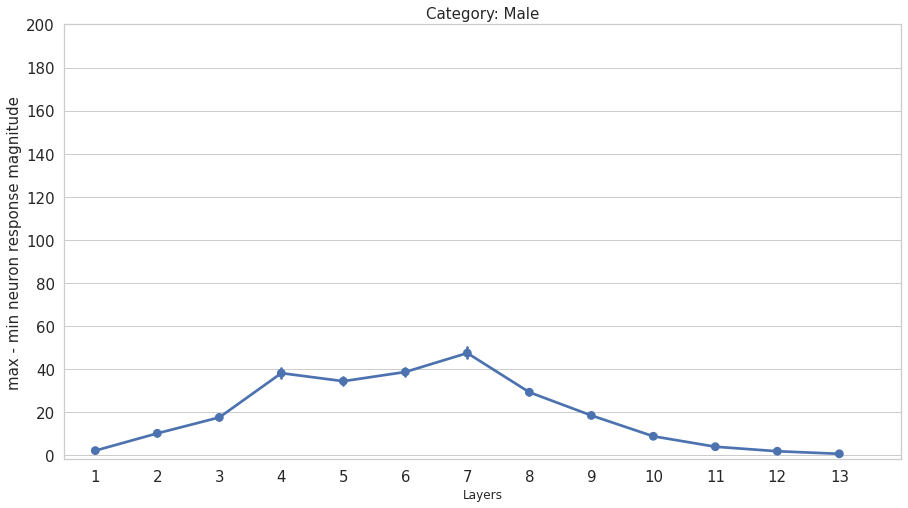

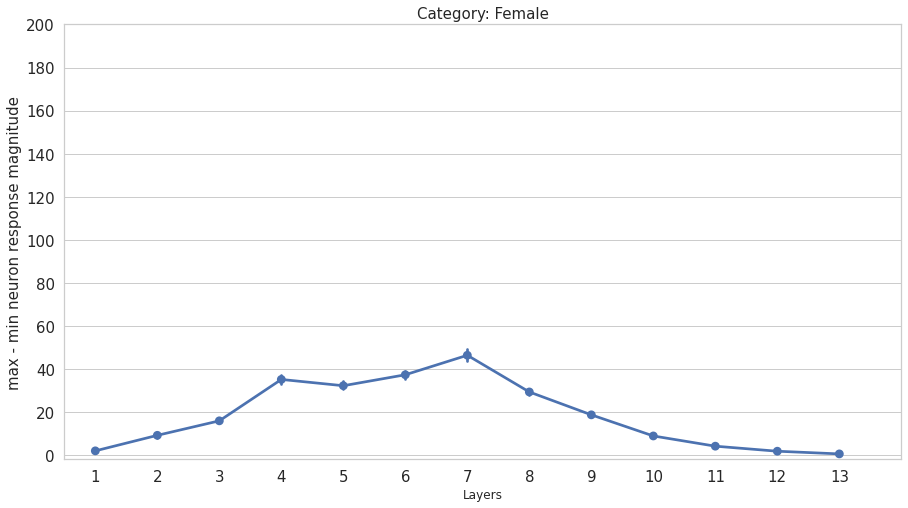

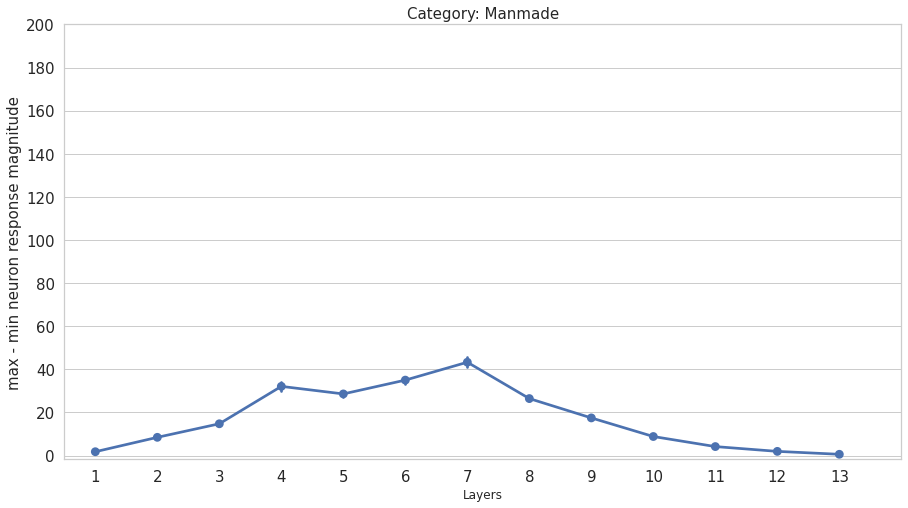

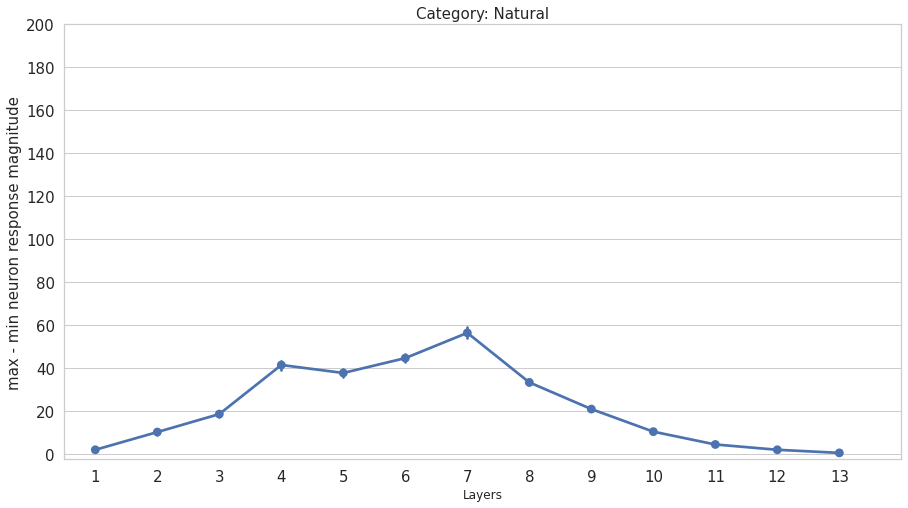

In [ ]:
for cat in range(ncats):
  plt_data = x[cat]
  plt.figure(figsize= (15,8))
  sns.pointplot(data = plt_data)
  plt.xlabel('Layers')
  plt.xticks(np.arange(0,14),np.arange(1,14),size = 15)
  plt.ylabel('max - min neuron response magnitude',size = 15)
  plt.yticks(np.arange(0,201,20),size = 15)
  plt.title('Category: ' + categories[cat],size = 15)

# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score

def gen_attnmap(modifier,mask,category,bi,atype,rand_map):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: bool, optional
        Set to 'True' for random set of tuning values
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10
  
    #conv1_1 & conv1_2

    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          
          amap = np.ones((224,224,64),dtype='float32') +  mask[layer]
        attnmap.append(amap)
        
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((112,112,128),dtype='float32') +  mask[layer]
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((56,56,256),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((28,28,512),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((14,14,512),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1,
                 rand_map = 0):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: int, optional
        0 = No randomization
        1 = Shuffled tuning values
        2 = Same tuning values
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    
    epochs = 30    
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype,rand_map)     
        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()
        
        f_train = model.predict(data_train)     
    
        f_test = model.predict(data_test)
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  
        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])
    
        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1]

    return t_acc



### Driver
This is the big loop which applies attention at each layer separately as a function of different attentional strengths. 
PS. This is very heavy and requires hours to finish.


In [115]:
#@title Multiplicative and bidirectionality corrected

from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(0,10,1): #Calling for different attn strengths
  grand_acc = [[] for i in range(ncats)] 
  for cat in range(ncats): # Iterating over 6 categories
    tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
          
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:])) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
    top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,
                              top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1,
                              rand_map = 2 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([13,4,1])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('tun_accuracy_multi' + str(atstrng),grand_acc)



Category of interest:  Male
(150, 224, 224, 3) (30, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 0s 18ms/step - loss: 0.6641 - accuracy: 0.7333
Category of interest:  Female
(150, 224, 224, 3) (30, 224, 224, 3)
1/1 [==============================] - 0s 17ms/step - loss: 0.6191 - accuracy: 0.8333
Category of interest:  Manmade
(150, 224, 224, 3) (30, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step - loss: 0.1913 - accuracy: 0.9000
Category of interest:  Natural
(150, 224, 224, 3) (30, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step - loss: 1.8124 - accuracy: 0.5333
Category of interest:  Male
(150, 224, 224, 3) (30, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step - loss: 1.3650 - accuracy: 0.7000
Category of interest:  Female
(150, 224, 224, 3) (30, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step - loss: 1.2489 - accuracy: 0.7667
Category of interest:  Manmade
(150, 224, 224, 3) (30, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step - loss: 0.2982 - accuracy: 0.

In [ ]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('tun_accuracy_new' + str(atstrng),grand_acc)

Text(0, 0.5, 'Avg. acc.')

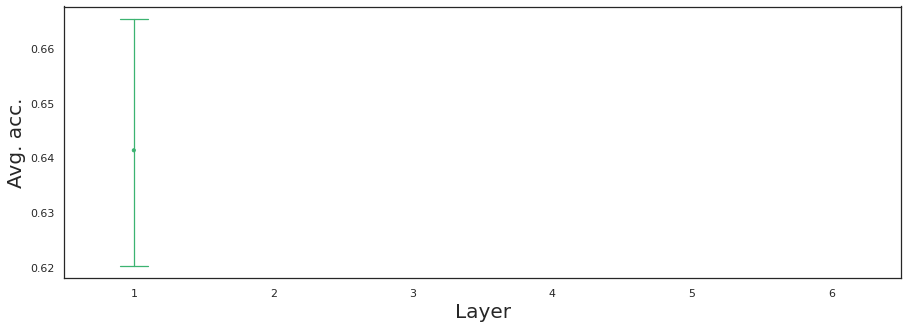

In [ ]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
          
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
acc = [0]*6
for cat in range(ncats):
  tf.keras.backend.clear_session()

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 4]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 4]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it) 

  features_test = model.predict(test_it) 


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 80
  train_data = features_train
  train_labels = to_categorical([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = to_categorical([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.7500
[0.6439995765686035, 0.75]
Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 0s 4ms/step - loss: 0.8515 - accuracy: 0.7000
[0.8515356779098511, 0.699999988079071]
Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00005: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 1.0024 - accuracy: 0.6875
[1.0023987293243408, 0.6875]
Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Epoch 00003: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 2.0552 - accuracy: 0.5750
[2.0551769733428955, 0.574999988079071]


0.45208332935969037

# Calculation for control condition

Text(0.5, 0, 'Category')

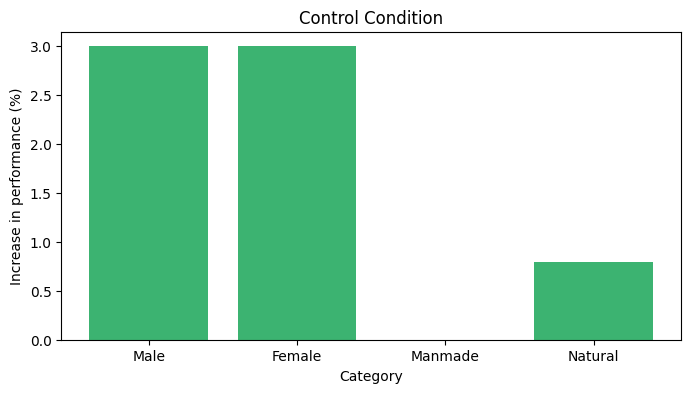

In [ ]:
plt_data = np.array((3,3,0,0.8))
fig = plt.figure(figsize = (8,4))
plt.bar(x = ['Male','Female','Manmade','Natural'],
        height = plt_data.T,
        color = 'mediumseagreen')
plt.title('Control Condition')
plt.ylabel('Increase in performance (%)')
plt.xlabel('Category')


# Plots

### Layer wise plot
This code generates the plot for performance increase as a function of attention applied at each layer separately.

In [ ]:
acc = [0.69,0.72,0.85,0.58]
import numpy as np
import matplotlib.pyplot as plt

x = np.load('tun_accuracy_multi0.0.npy')
x = np.expand_dims(x,0)

for i in np.arange(0.5,10,0.5):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))



x = np.amax(x,0)

plt_data = np.zeros((ncats,1))
for i in range(ncats):
  for j in range(13):
    plt_data[i,j] = x[i,j] - acc[i]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = plt_data*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
                   
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
plt.yticks(fontsize = 20)
plt.ylim(0,30)
plt.title('Attention by tuning curve, bias stng: 0 - 10.5',size = 15)
ax.set_ylabel('Performance Increase (%)',size = 20)

In [ ]:
# NOT REQUIRED FOR NOW
#grad_acc = plt_data
#tun_acc = plt_data

from scipy import stats
pval = np.zeros(13)

for i in range(13):
  _,pval[i] = stats.ttest_ind(tun_acc[:,i],grad_acc[:,i],equal_var=False)

pval

### Category wise plot
This code generates the plot for performance increase as a function of category and attention applied at each layer separately.

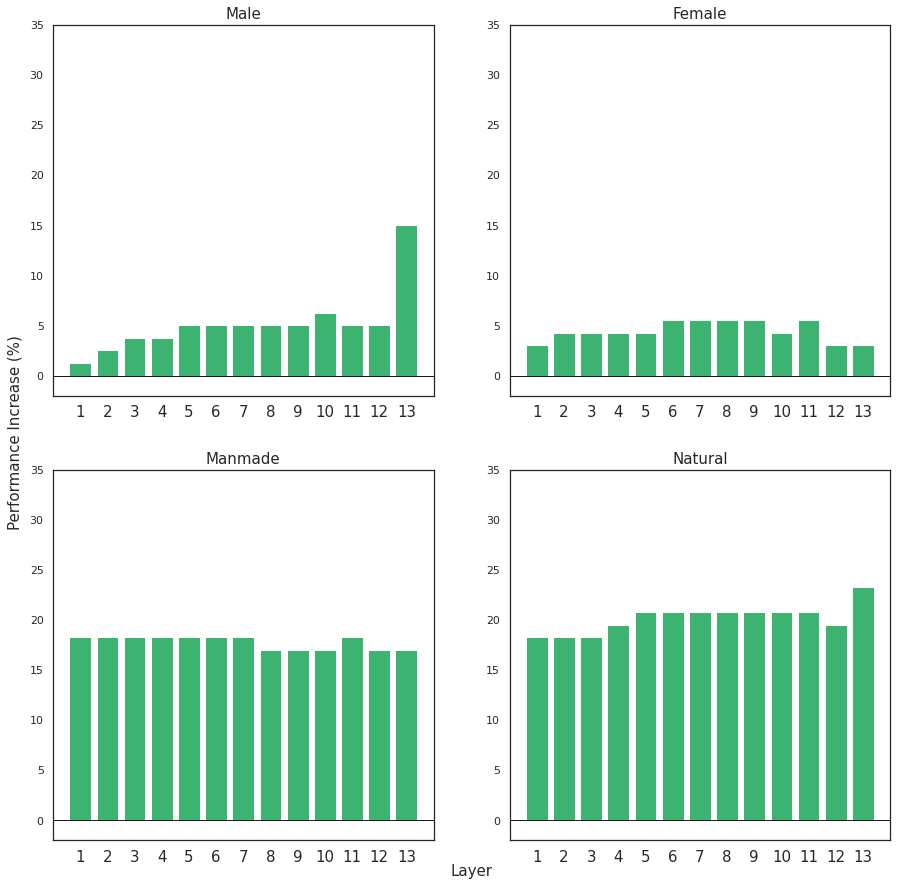

In [ ]:
acc = [0.75,0.72,0.68,0.58]

gacc = np.load('tun_accuracy_multi0.0.npy')
gacc = np.expand_dims(gacc,0)

for i in np.arange(0.5,10,0.5):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
strngs = np.arange(0.5,5,1)
'''
for i in np.arange(1,11,1):
  temp = np.load('tun_accuracy_add' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
strngs = np.concatenate((strngs,np.arange(1,6,1)))'''
y = np.amax(gacc,0).T


plt_data = np.zeros((13,4))
for i in range(13):
  for j in range(4):
    plt_data[i,j] = y[i,j] - acc[j]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
layer = 0
f,axes = plt.subplots(2,2,figsize=(15,15))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Layer",size = 15)
plt.ylabel("Performance Increase (%)",size = 15)
for x in range(2):
  for y in range(2):
    axes[x,y].bar(x = np.arange(0,13),height = plt_data[:,layer]*100,color = 'mediumseagreen')
    axes[x,y].set_xticklabels(np.arange(1,14),size = 15)
    axes[x,y].set_xticks(np.arange(0,14))
    axes[x,y].set_title(categories[layer],size = 15)
    axes[x,y].set_ylim(-2,35)
    axes[x,y].set_xlim(-1,13)
    axes[x,y].hlines(y = 0,xmin= -1,xmax = 13)
    layer+=1
  